In [1]:
import numpy as np
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
import pandas as pd
from sklearn.metrics import mutual_info_score
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mutual_info_score
from scipy.stats import entropy

plt.style.use('../standard.mplstyle')
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

In [2]:


def compute_ami(time_series, max_delay):
    """Compute average mutual information for different time delays."""
    ami_values = []
    for delay in range(1, max_delay + 1):
        ami = mutual_info_score(time_series[:-delay], time_series[delay:])
        ami_values.append(ami)
    return np.array(ami_values)

def find_local_minima_ami(time_series, max_delay):
    ami_values = compute_ami(time_series, max_delay)
    
    # Find local minima indices
    local_minima_indices = (np.diff(np.sign(np.diff(ami_values))) > 0).nonzero()[0] + 1
    local_minima_values = ami_values[local_minima_indices]
    
    return local_minima_indices, local_minima_values, ami_values

def compute_derivative(values):
    """Compute the derivative of a numpy array."""
    return np.gradient(values, edge_order=2)

def find_optimal_delay(local_minima_indices, derivative_adaf):
    for index in local_minima_indices:
        if index < len(derivative_adaf) and derivative_adaf[index] < 0:
            return index  # Return the index where the first local minimum has a decreasing derivative of ADAF
    return None  # Return None if no such index is found

def optimal_delay_ami(time_series, max_delay=100, plot=False):
    """Find the optimal time delay using the first local minimum of AMI."""

    local_minima_indices, local_minima_values, ami_values = find_local_minima_ami(time_series, max_delay)
    optimal_delay_index = find_optimal_delay(local_minima_indices, derivative_adaf)
    if optimal_delay_index is not None:
        print(f'Optimal time delay: {optimal_delay_index + 1}')  # Adding 1 because delay starts from 1
        min_delay = optimal_delay_index + 1
    else:
        if len(local_minima_indices) > 1:
            print(f'No optimal time delay found with the given criteria... using first local minima: {local_minima_indices[0]}')
            min_delay = local_minima_indices[0]
        else:
            print(f'No optimal time delay found with the given criteria... using global minimum: {np.argmin(ami_values) + 1}')
            min_delay = np.argmin(ami_values) + 1  # Fallback to global minimum if no local minimum is found
        
    if plot:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, max_delay + 1), ami_values, marker='o')
        plt.axvline(x=min_delay, color='r', linestyle='--', label=f'Optimal delay: {min_delay}')
        plt.xlabel('Delay')
        plt.ylabel('Average Mutual Information')
        plt.title('Average Mutual Information vs Delay')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return min_delay

def plot_acf(time_series, nlags=100):
    # Compute the autocorrelation function
    acf_values = acf(time_series, nlags=nlags)
    
    # Find the first zero crossing
    first_zero = np.where(acf_values < 0)[0][0] if any(acf_values < 0) else len(acf_values)
    print(f'First zero in ACF: {first_zero}')
    
    # Find the autocorrelation time (decay to 1/e)
    autocorr_time = np.where(acf_values < 1/np.e)[0][0] if any(acf_values < 1/np.e) else len(acf_values)
    print(f'ACF time: {autocorr_time}')
    
    # Plot the ACF
    plt.figure(figsize=(10, 5))
    plt.plot(acf_values, marker='o', linestyle='-', label='ACF')
    plt.axvline(x=first_zero, color='r', linestyle='--', label='First Zero Crossing')
    plt.axvline(x=autocorr_time, color='g', linestyle='--', label='Autocorrelation Time (1/e decay)')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title('Autocorrelation Function')
    plt.legend()
    plt.grid(True)
    plt.show()

def compute_adaf(time_series, max_delay):
    """Compute ADAF values for different time delays."""
    adaf_values = []
    for delay in range(1, max_delay + 1):
        distances = []
        for i in range(len(time_series) - delay):
            distance = np.abs(i - (i + delay))
            distances.append(distance)
        adaf_values.append(np.mean(distances))
    return np.array(adaf_values)

def compute_derivative_adaf(adaf_values):
    """Compute the derivative of the ADAF values."""
    derivative_adaf = np.diff(adaf_values)
    return derivative_adaf

def find_first_local_minimum(ami_values):
    """Find the first local minimum in the average mutual information values."""
    for i in range(1, len(ami_values) - 1):
        if ami_values[i] < ami_values[i - 1] and ami_values[i] < ami_values[i + 1]:
            return i  # Return the delay corresponding to the first local minimum
    return None  # Return None if no local minimum is found



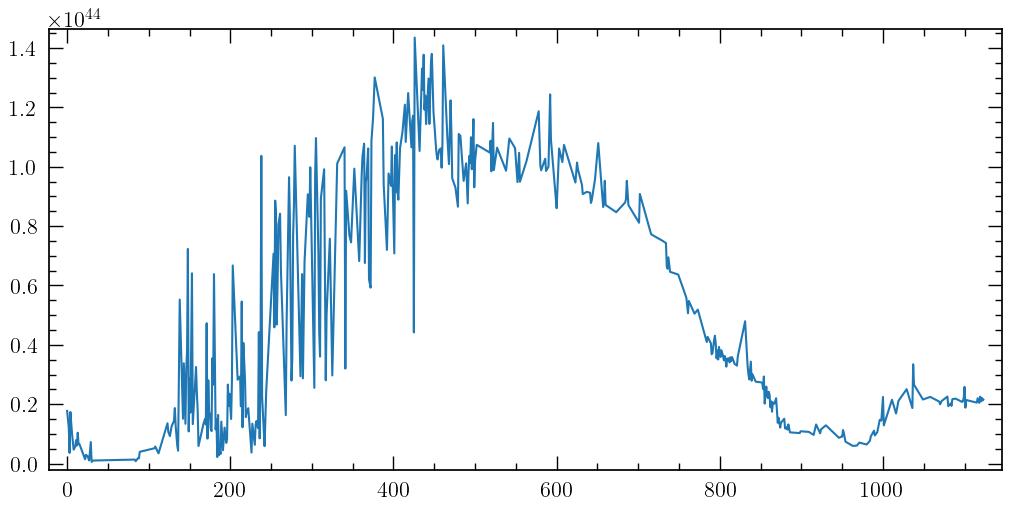

In [38]:
plt.plot(lc)
# plt.plot(pred_lc)

In [ ]:

df = pd.read_csv('1ES_binned_lc.csv')
pred_df = pd.read_csv('1ES_pred_DHO_lc.csv')

lc, pred_lc = df['scaled lumin'].values, pred_df['lumin'].values

# Example usage:
# time_series = binned_ts 
max_delay = 100  # Maximum delay to consider

for ts in [lc, pred_lc]:
    # adaf_values = compute_adaf(ts, max_delay)  # Compute ADAF
    # derivative_adaf = compute_derivative(adaf_values)  # Compute derivative of ADAF
    # local_minima_indices, local_minima_values, ami_values = find_local_minima_ami(ts, max_delay)
    # optimal_delay = optimal_delay_ami(ts, max_delay, plot=True)
    # print(f'Optimal time delay: {optimal_delay}')
    
    MI = mutual_info_knn(ts, max_delay)
    first_min = find_first_local_minimum(MI)
    print(f'First MI minimum: {first_min}')
# plot_acf(time_series, nlags=100)

plt.plot(MI)

In [27]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mutual_info_score
import numpy as np

def mutual_info_knn(time_series, max_delay, n_neighbors=3):
    mi_values = []
    for delay in range(1, max_delay + 1):
        # Create pairs for mutual information calculation
        pairs = np.array(list(zip(time_series[:-delay], time_series[delay:])))
        # Use NearestNeighbors to compute distances
        nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(pairs)
        distances, _ = nbrs.kneighbors(pairs)
        # Estimate mutual information based on distances
        ami = np.mean(np.log(n_neighbors / distances[:, -1]))
        mi_values.append(ami)
    return np.array(mi_values)


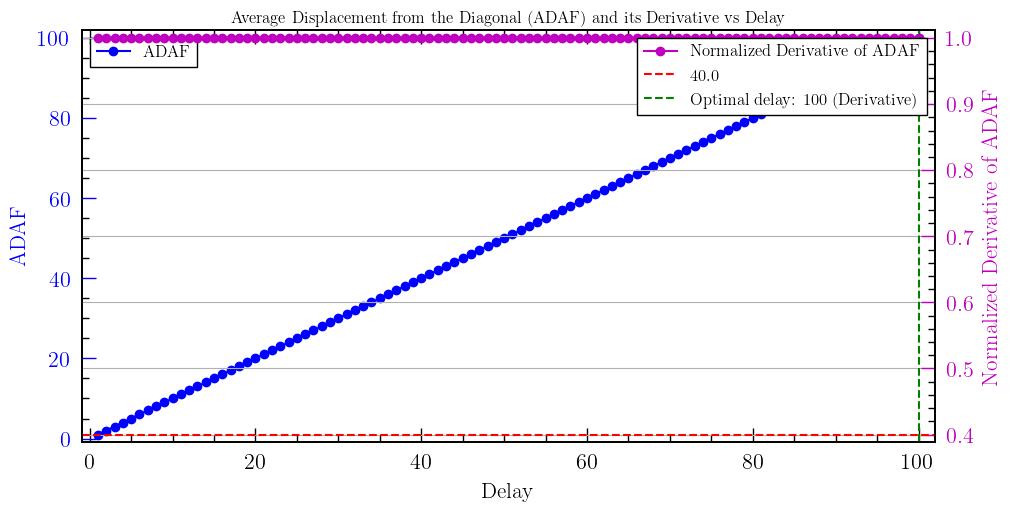

Optimal time delay based on 40% decay in derivative of ADAF: 100


In [40]:
import numpy as np
import matplotlib.pyplot as plt

def compute_derivative(values):
    """Compute the derivative of a numpy array."""
    return np.gradient(values, edge_order=2)

def find_optimal_delay_adaf_derivative(time_series, decay_threshold=0.4, max_delay=100):
    # Compute the ADAF values
    adaf_values = compute_adaf(time_series, max_delay)
    
    # Compute the derivative of the ADAF
    derivative_adaf = compute_derivative(adaf_values)
    
    # Normalize the derivative of ADAF (so that the initial value is 1)
    normalized_derivative_adaf = np.abs(derivative_adaf / derivative_adaf[0])
    
    # Find the delay where the normalized derivative has decayed by the specified threshold
    indices = np.where(normalized_derivative_adaf <= decay_threshold)[0]
    decay_delay_derivative = indices[0] + 1 if len(indices) > 0 else max_delay  # Adding 1 because delay starts from 1
    
    # Plotting
    fig, ax1 = plt.subplots(figsize=(10, 5))
    
    # Plot ADAF vs. Delay
    ax1.plot(range(1, max_delay + 1), adaf_values, 'b-', marker='o', label='ADAF')
    ax1.set_xlabel('Delay')
    ax1.set_ylabel('ADAF', color='b')
    ax1.tick_params('y', colors='b')
    ax1.set_title('Average Displacement from the Diagonal (ADAF) and its Derivative vs Delay')
    ax1.legend(loc='upper left')
    
    # Create twin axis for the derivative of ADAF
    ax2 = ax1.twinx()
    ax2.plot(range(1, max_delay + 1), normalized_derivative_adaf, 'm-', marker='o', label='Normalized Derivative of ADAF')
    ax2.axhline(y=decay_threshold, color='r', linestyle='--', label=f'{decay_threshold * 100}% Decay Threshold (Derivative)')
    ax2.axvline(x=decay_delay_derivative, color='g', linestyle='--', label=f'Optimal delay: {decay_delay_derivative} (Derivative)')
    ax2.set_ylabel('Normalized Derivative of ADAF', color='m')
    ax2.tick_params('y', colors='m')
    ax2.legend(loc='upper right')
    
    plt.grid(True)
    plt.show()
    
    return decay_delay_derivative, adaf_values, normalized_derivative_adaf

# Example usage:
# time_series = binned_ts 
max_delay = 100  # Maximum delay to consider
decay_threshold_derivative = 0.4  # Define the decay threshold for the derivative (e.g., 40%)
optimal_delay_derivative, adaf_values, normalized_derivative_adaf = find_optimal_delay_adaf_derivative(lc, decay_threshold_derivative, max_delay)
print(f'Optimal time delay based on 40% decay in derivative of ADAF: {optimal_delay_derivative}')


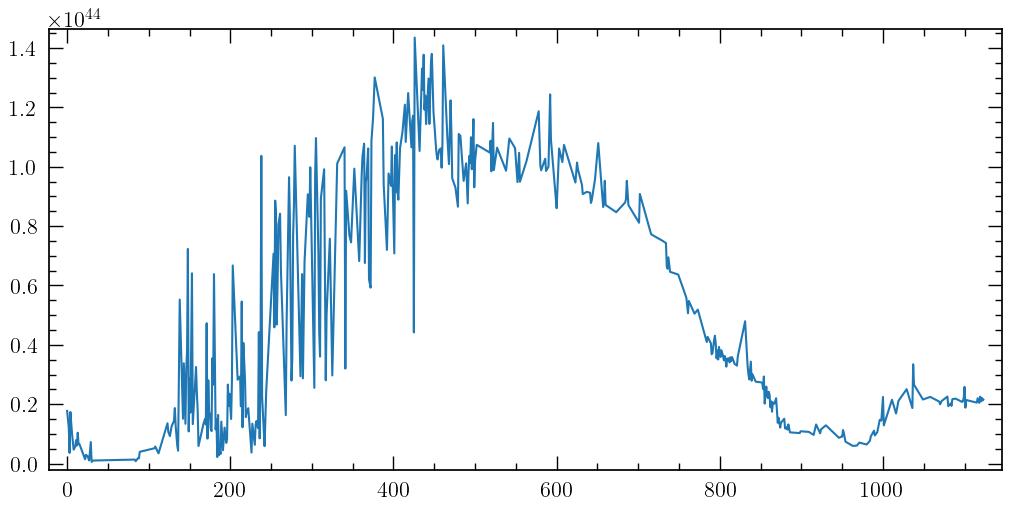

In [37]:
plt.plot(lc)

In [29]:
def caos_method(time_series, max_embedding_dimension=10):
    N = len(time_series)
    E1 = np.zeros(max_embedding_dimension - 1)
    E2 = np.zeros(max_embedding_dimension - 1)
    
    for m in range(1, max_embedding_dimension):
        # Reconstruct the phase space for m and m+1 dimensions
        Ym = np.array([time_series[i:N-m+i+1] for i in range(m)]).T
        Ym1 = np.array([time_series[i:N-m+i] for i in range(m+1)]).T

        # Find the nearest neighbors in m dimensions
        nbrs_m = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(Ym)
        distances_m, indices_m = nbrs_m.kneighbors(Ym)

        # Find the nearest neighbors in m+1 dimensions
        nbrs_m1 = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(Ym1)
        distances_m1, indices_m1 = nbrs_m1.kneighbors(Ym1)

        # Ensure distances arrays are of the same length for E1 calculation
        len_distances = min(len(distances_m), len(distances_m1))
        
        # Calculate E1
        E1[m-1] = np.mean(np.abs(distances_m1[:len_distances, 0] - distances_m[:len_distances, 1])) / np.mean(distances_m[:len_distances, 1])
        
        # Calculate E2 using the nearest neighbor distances in (m+1)-dimensional space
        nn_distances_m1 = distances_m1[indices_m[:len_distances, 0], 0]
        E2[m-1] = np.mean(nn_distances_m1) / np.mean(distances_m[:len_distances, 1])

    # Find the optimal embedding dimension as the first dimension where E1(m) doesn't change significantly
    optimal_dimension = np.where(np.abs(np.diff(E1)) < 0.05)[0]
    if len(optimal_dimension) > 0:
        optimal_dimension = optimal_dimension[0] + 1  # Adding 1 because dimension starts from 1
    else:
        optimal_dimension = max_embedding_dimension

    return optimal_dimension, E1, E2

# Example usage:
optimal_dimension, E1, E2 = caos_method(ts, max_embedding_dimension=10)
print(f'Optimal embedding dimension: {optimal_dimension}')


Optimal embedding dimension: 1


In [ ]:
def check_derivative_behavior(derivative_adaf, time_index):
    second_derivative = np.gradient(derivative_adaf, edge_order=2)
    behavior = "increasing" if second_derivative[time_index] > 0 else "decreasing"
    return behavior

# Example usage:
time_index = 14  # Replace with your specific time index or delay
behavior = check_derivative_behavior(normalized_derivative_adaf, time_index)
print(f'The derivative of ADAF is {behavior} at time index {time_index}.')


In [34]:
from nolitsa import data, dimension


# Range of embedding dimensions to test
dims = np.arange(1, 10)

for ts in [lc, pred_lc]:
    # Calculate E1 and E2 using Cao's method
    E1, E2 = dimension.afn(ts, dim=dims)

    # Find the optimal embedding dimension
    optimal_dimension = np.argwhere(E2 < 0.05)[0] if np.any(E2 < 0.05) else len(dims)

    # # Example usage:
    # optimal_dimension = find_optimal_dimension(E1, E2)
    print(f"Optimal dimension: {optimal_dimension}")


Optimal dimension: 9
Optimal dimension: 9


First MI minimum: 12
First MI minimum: 9


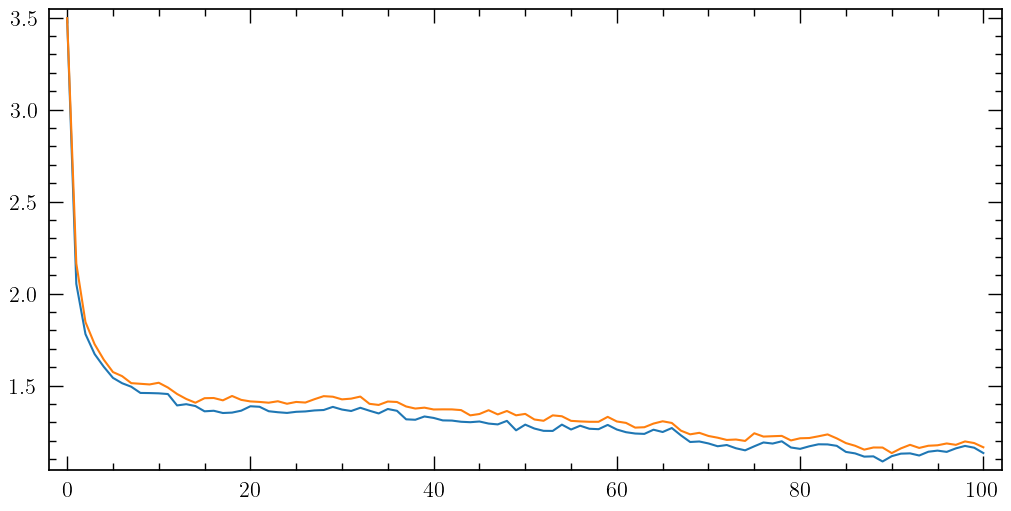

In [4]:
import numpy as np
from sklearn.metrics import mutual_info_score

def mutual_information(time_series, max_delay):
    # Discretize the time series based on quantiles
    def discretize(series, bins):
        quantiles = np.linspace(0, 1, bins + 1)
        bin_edges = np.quantile(series, quantiles)
        digitized = np.digitize(series, bin_edges[1:-1])
        return digitized

    bins = int(np.sqrt(len(time_series)))  # Rule-of-thumb for number of bins
    discretized_series = discretize(time_series, bins)

    mi_values = []
    for tau in range(max_delay + 1):
        # Calculate mutual information between the time series and its delayed version
        if tau == 0:
            mi = mutual_info_score(discretized_series, discretized_series)
        else:
            mi = mutual_info_score(discretized_series[:-tau], discretized_series[tau:])
        mi_values.append(mi)

    return mi_values

# Example usage
max_delay = 100  # Maximum time delay to compute mutual information for
mi = mutual_information(lc, max_delay)
plt.plot(mi)
first_min = find_first_local_minimum(mi)
print(f'First MI minimum: {first_min}')
# for delay, value in enumerate(mi):
#     print(f"Delay: {delay}, Mutual Information: {value}")

mi = mutual_information(pred_lc, max_delay)
plt.plot(mi)
first_min = find_first_local_minimum(mi)
print(f'First MI minimum: {first_min}')
# for delay, value in enumerate(mi):
#     print(f"Delay: {delay}, Mutual Information: {value}")


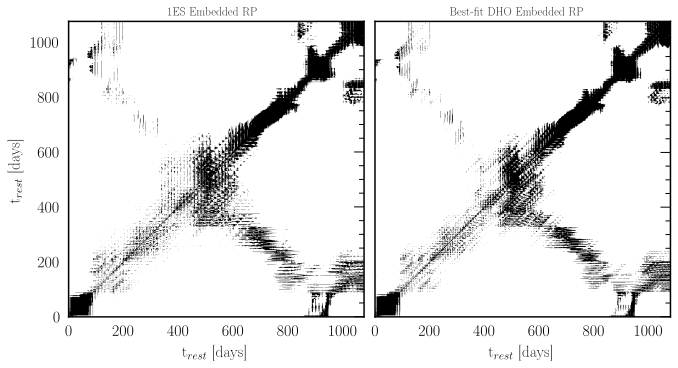

In [7]:
from pyunicorn.timeseries import RecurrencePlot

# y, yerr = scale_lc(df['lumin'].values, df['error'].values)
# pred_y, pred_yerr = scale_lc(pred_df['lumin'].values, pred_df['error'].values)

rp = RecurrencePlot(df['scaled lumin'].values, metric='supremum', silence_level=2, local_recurrence_rate=0.1, tau=12, dim=5)
pred_rp = RecurrencePlot(pred_df['lumin'].values, metric='supremum', silence_level=2, local_recurrence_rate=0.1, tau=9, dim=6)

fig, (ax, ax2) = plt.subplots(figsize=(10,5), ncols=2, layout='compressed')
ax.matshow(rp.recurrence_matrix(), origin='lower', interpolation='none', cmap='Greys')
ax2.matshow(pred_rp.recurrence_matrix(), origin='lower', interpolation='none', cmap='Greys')
for axis in (ax, ax2):
    axis.set_xlabel(r't$_{rest}$ [days]')
ax.tick_params(which="both", axis="both", labeltop=False, labelbottom=True, top=False, left=False, bottom=False)
ax2.tick_params(which="both", axis="both", labeltop=False, labelbottom=True, top=False, left=False, bottom=False, labelleft=False)
# axis.tick_params(which="both", axis="both", left=False, top=False, right=False, bottom=False, labelbottom=False, labelleft=False, labeltop=False)
ax.set_ylabel(r't$_{rest}$ [days]')
# ax.set_title('1ES Unembedded RP')
# ax2.set_title('Best-fit DHO Unembedded RP')
ax.set_title('1ES Embedded RP')
ax2.set_title('Best-fit DHO Embedded RP')
# plt.savefig('../plots/1ES_unembedded_RP_compared_DHO.pdf', bbox_inches='tight')
plt.show()

In [8]:
print("RR DET LAM TT LMAX VMAX LMEAN LENTR VENTR CENTR")
print(rp.recurrence_rate(), rp.determinism(), rp.laminarity(), rp.trapping_time(), rp.max_diaglength(), rp.max_vertlength(), rp.average_diaglength(), rp.average_vertlength(), rp.diag_entropy(), rp.vert_entropy(), rp.complexity_entropy())
print(pred_rp.recurrence_rate(), pred_rp.determinism(), pred_rp.laminarity(), pred_rp.trapping_time(), pred_rp.max_diaglength(), pred_rp.max_vertlength(), pred_rp.average_diaglength(), pred_rp.average_vertlength(), pred_rp.diag_entropy(), pred_rp.vert_entropy(), pred_rp.complexity_entropy())




RR DET LAM TT LMAX VMAX LMEAN LENTR VENTR CENTR
0.09944065173228672 0.8681550317315426 0.9409602752579727 9.08227104997561 359 107 6.756570823772485 9.08227104997561 2.1992664869253593 2.719520975107225 0.12267149945069693
0.09916245863184685 0.8994077385752427 0.9568156410055589 10.253157503705188 528 107 7.93252032519519 10.253157503705188 2.251440779195124 2.8329302782080434 0.28540299852995954


In [10]:
# Perform DFA
import nolds
y, pred_y = df['scaled lumin'].values, pred_df['lumin'].values

alpha = nolds.dfa(y)
print(f"Original data -- Scaling exponent (alpha) from DFA: {alpha}")

alpha = nolds.dfa(pred_y)
print(f"Pred DHO -- Scaling exponent (alpha) from DFA: {alpha}")



Original data -- Scaling exponent (alpha) from DFA: 1.1756176572948436
Pred DHO -- Scaling exponent (alpha) from DFA: 1.2264882554748509


In [ ]:
import numpy as np

def perform_global_svd(time_series, dim, delay, ldim=None):
    length = len(time_series)
    series = time_series - np.mean(time_series)
    
    # Create trajectory matrix
    traj_matrix = np.column_stack([series[i:length - dim * delay + i + 1:delay] for i in range(dim)])
    
    # Perform SVD
    U, sigma, Vt = np.linalg.svd(traj_matrix, full_matrices=False)
    
    if ldim and ldim <= dim:
        U = U[:, :ldim]
        sigma = sigma[:ldim]
        Vt = Vt[:ldim, :]
    
    # Reconstruct the dynamics with the desired number of dimensions
    reconstructed = np.dot(U, np.dot(np.diag(sigma), Vt))
    
    return U, sigma, Vt, reconstructed

# Example usage
dim = 2  # Embedding dimension
delay = 1  # Delay
ldim = 2  # Number of dimensions for projection, optional

U, sigma, Vt, reconstructed = perform_global_svd(time_series, dim, delay, ldim)

# U, sigma, Vt are the SVD components
# reconstructed is the time series reconstructed from the first ldim dimensions


In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def zeroth_order_fit(time_series, embed, delay, min_neighbors, steps, epsilon_factor, epsilon_init=1e-3):
    # Reshape time series based on embedding dimension and delay
    def embed_series(series, embed, delay):
        shape = (series.size - (embed - 1) * delay, embed)
        strides = (series.strides[0], series.strides[0] * delay)
        return np.lib.stride_tricks.as_strided(series, shape=shape, strides=strides)

    embedded = embed_series(time_series, embed, delay)
    nbrs = NearestNeighbors(n_neighbors=min_neighbors, algorithm='auto').fit(embedded[:-steps])
    distances, indices = nbrs.kneighbors(embedded[:-steps])

    # Initialize epsilon and errors
    epsilon = epsilon_init / epsilon_factor
    errors = np.zeros(steps)

    for step in range(1, steps + 1):
        epsilon *= epsilon_factor
        mask = distances[:, -1] < epsilon
        for i, row in enumerate(indices[mask]):
            forecast = np.mean(embedded[row, -1])
            actual = embedded[mask][i, -1 + step]
            errors[step - 1] += (forecast - actual) ** 2

    forecast_errors = np.sqrt(errors / len(embedded))
    return forecast_errors

# Example usage
embed = 2
delay = 1
min_neighbors = 30
steps = 1
epsilon_factor = 1.2
forecast_errors = zeroth_order_fit(time_series, embed, delay, min_neighbors, steps, epsilon_factor)

print(f"Forecast Errors: {forecast_errors}")


In [3]:
import numpy as np

def calculate_rms_error(actual, predicted):
    return np.sqrt(np.mean((actual - predicted) ** 2))

# Example usage:
actual = np.array([1, 2, 3, 4, 5])  
predicted = np.array([1.1, 1.9, 3.2, 3.9, 4.8]) 

rms_error = calculate_rms_error(actual, predicted)
print(f'RMS Error: {rms_error}')


RMS Error: 0.1483239697419134


In [ ]:
# Example usage:
fnn_ratio = false_nearest_neighbors(pred_y, max_dim=10, delay=8, rt=10.0)

for dim, ratio in enumerate(fnn_ratio, start=2):
    print(f"Dimension: {dim}, FNN ratio: {ratio}")


In [ ]:
import numpy as np

# Example usage:
embedded_series = embed_series(time_series, embedding_dimension, time_delay)
predicted_series = [predict_next_state(embedded_series, state) for state in embedded_series]
prediction_error = calculate_prediction_error(time_series, predicted_series)
